In [1]:
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt


### <center> BEST OF CALL OPTION </center>
The payoff is $h_T = \big(\max(X_T^1, X_T^2)-K \big)_+$ with $ \mathrm{d}X_t^j = X_t^j(r\mathrm{d}t + \sigma^j\mathrm{d}W_t^j)$ and $\mathrm{d}<W^1,W^2>_t = \rho \mathrm{d}t$

Let's define the pseudo control variable $k_T = (\sqrt{X^1_TX^2_T} - K)_+$ 
$\mathbb{E}[k_T] = e^{rT}\textrm{Call}^{\textrm{BS}}( \sqrt{x_1x_2}e^{-\frac{1}{4}(\sigma_1^2 + \sigma_2^2)T + \frac{1}{2}\sigma_{\textrm{BS}}^2T}, T, K, \sigma_{\textrm{BS}}, r)$ with $\sigma_{\textrm{BS}}^2 = \frac{1}{4}(\sigma_1^2 + \sigma_2^2 + 2\sigma_1\sigma_2\rho)$

In [17]:
def compute_call_BS(S0, T, K, sigma, r, q=0, t=0):
    d_plus = (1./(sigma*np.sqrt(T-t)))*np.log(S0/(K*np.exp(-(r-q)*(T-t)))) + 0.5*sigma*np.sqrt(T-t)
    d_moins = d_plus - sigma*np.sqrt(T-t)
    call = S0*np.exp(-q*(T-t))*norm.cdf(d_plus) - K*np.exp(-r*(T-t))*norm.cdf(d_moins)
    return call

In [24]:
def simulate_best_of_call(N_trajectories, confidence, S_1, S_2, rho, sigma_1, sigma_2, T, strike, r):
    W = np.random.multivariate_normal(mean = np.array([0.,0.]),
                                     cov = np.array([[T, rho*T],[rho*T, T]]),
                                     size = N_trajectories)
    initial_price = np.array([S_1, S_2])
    sigma = np.array([sigma_1,sigma_2])
    X = initial_price*np.exp((r - 0.5*(sigma**2.0))*T + sigma*W)
    
    h_T = np.maximum(np.maximum(X[:, 0], X[:, 1]) - strike, 0)
    k_T = np.maximum(np.sqrt(X[:,0]*X[:, 1]) - strike, 0)
    
    sigma_BS = 0.5*np.sqrt(sigma_1**2.0 + sigma_2**2.0 + 2*sigma_1*sigma_2*rho)
    initial = np.sqrt(S_1*S_2)*np.exp(-0.25*(sigma_1**2.0+sigma_2**2.0)*T + 0.5*T*sigma_BS**2.0)
    esp_k_T = np.exp(r*T)*compute_call_BS(
                    S0 = initial,
                    T = T,
                    K = strike,
                    sigma = sigma_BS,
                    r = r)
    
    price = np.mean(h_T)
    std = np.std(h_T)
    confidence_interval_size = (norm.ppf((1.+confidence)/2.)*std)**2.0/N_trajectories
    
    price_diff = h_T - k_T
    std_controled = np.std(price_diff)
    price_controled = np.mean(price_diff) + esp_k_T
    confidence_interval_size = (norm.ppf((1.+confidence)/2.)*std_controled)**2.0/N_trajectories
    
    return price, confidence_interval_size, price_controled, confidence_interval_size

    
    

In [25]:
simulate_best_of_call(N_trajectories = 1000, 
                      confidence = 0.95,
                      S_1 = 100, 
                      S_2 = 95, 
                      rho = 0.5, 
                      sigma_1 = 0.1, 
                      sigma_2 = 0.2, 
                      T = 2.0,  
                      strike = 98, 
                      r = 0.03)

(17.214961405765578, 0.3223993640892842, 17.66626600564142, 0.3223993640892842)

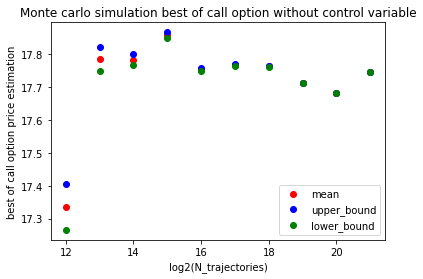

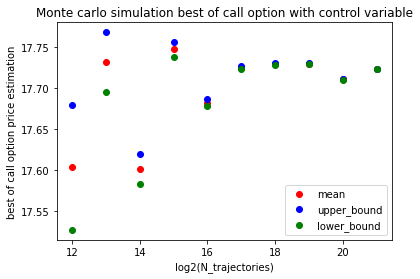

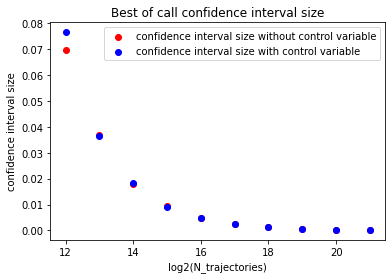

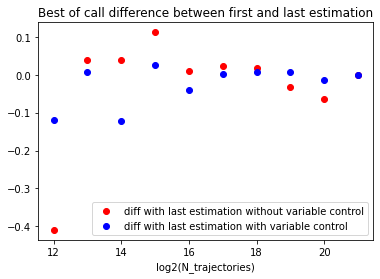

In [32]:
X = [int(2**k) for k in range(12,22)]
Y = [simulate_best_of_call(N_trajectories = x, 
                      confidence = 0.95, 
                      S_1 = 100, 
                      S_2 = 95, 
                      rho = 0.5, 
                      sigma_1 = 0.1, 
                      sigma_2 = 0.2, 
                      T = 2.0,  
                      strike = 98, 
                      r = 0.03) for x in X]

estimation_1 = np.array([y[0] for y in Y])
confidence_1 = np.array([y[1] for y in Y])

X_1 = range(12,22)
plt.scatter(X_1, estimation_1, c = 'red', label = 'mean')
plt.scatter(X_1, estimation_1+confidence_1, c = 'blue', label = 'upper_bound')
plt.scatter(X_1, estimation_1-confidence_1, c = 'green', label = 'lower_bound')
plt.title('Monte carlo simulation best of call option without control variable')
plt.xlabel('log2(N_trajectories)')
plt.ylabel('best of call option price estimation')
plt.legend()
plt.figure()

X = [int(2**k) for k in range(12,22)]
Y = [simulate_best_of_call(N_trajectories = x, 
                      confidence = 0.95, 
                      S_1 = 100, 
                      S_2 = 95, 
                      rho = 0.5, 
                      sigma_1 = 0.1, 
                      sigma_2 = 0.2, 
                      T = 2.0,  
                      strike = 98, 
                      r = 0.03) for x in X]

estimation = np.array([y[2] for y in Y])
confidence = np.array([y[3] for y in Y])

X_1 = range(12,22)
plt.scatter(X_1, estimation, c = 'red', label = 'mean')
plt.scatter(X_1, estimation+confidence, c = 'blue', label = 'upper_bound')
plt.scatter(X_1, estimation-confidence, c = 'green', label = 'lower_bound')
plt.title('Monte carlo simulation best of call option with control variable')
plt.xlabel('log2(N_trajectories)')
plt.ylabel('best of call option price estimation')
plt.legend()
plt.figure()

plt.scatter(X_1, confidence_1, c = 'red', label = 'confidence interval size without control variable')
plt.scatter(X_1, confidence, c = 'blue', label = 'confidence interval size with control variable')
plt.title('Best of call confidence interval size')
plt.xlabel('log2(N_trajectories)')
plt.ylabel('confidence interval size')
plt.legend()

plt.figure()
plt.scatter(X_1, estimation_1-estimation_1[-1], c = 'red', label = 'diff with last estimation without variable control')
plt.scatter(X_1, estimation- estimation[-1], c = 'blue', label = 'diff with last estimation with variable control')
plt.title('Best of call difference between first and last estimation')
plt.xlabel('log2(N_trajectories)')
plt.legend()